# Serial program NYC taxi data

Start of time for taking the sample of the run

In [1]:
import time
start = time.time()

Import the datasets

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
data = pd.read_csv("tripdata_2017-01.csv")
data = data.append(pd.read_csv("tripdata_2017-02.csv"), ignore_index=True)
zones = pd.read_csv("taxi+_zone_lookup.csv")

Transform variables and create new variables

In [3]:
to_convert=['passenger_count','RatecodeID','PULocationID','DOLocationID','payment_type']
data[to_convert].astype('category')
data['tpep_dropoff_datetime']= pd.to_datetime(data['tpep_dropoff_datetime'])
data['tpep_pickup_datetime']= pd.to_datetime(data['tpep_pickup_datetime'])
data['hour_pickup'] = data['tpep_pickup_datetime'].dt.hour
data = data[data['total_amount']>0]
data = data[data['trip_distance']>0]

data = pd.merge(data, zones[['LocationID', 'Borough']], how='left', left_on='PULocationID',right_on = 'LocationID').rename(columns={'Borough' : 'PUBorough'})

data = pd.merge(data, zones[['LocationID', 'Borough']], how='left', left_on='DOLocationID',right_on = 'LocationID').rename(columns={'Borough' : 'DOBorough'})

data = data.drop(columns = ['LocationID_x','LocationID_y'])

data['short/long'] = np.where(data['trip_distance']>=20, "long", "short")
prep_end = time.time()

In [4]:
#data

Get the average speed for each one of the trips

In [5]:
avg_speed_start = time.time()
data['trip_time'] = data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']
data['trip_time'] = data['trip_time']/ np.timedelta64(1, 'h')
data = data[data['trip_time']>0]
data['avg_speed'] = data['trip_distance']/data['trip_time']
data = data[data['avg_speed']>0]
data = data[data['avg_speed']<150]


Get the average speed per hour taking as reference the pickup time.

In [6]:
data1 = data.groupby(['hour_pickup']).mean().reset_index()
avg_speed_end = time.time()
#data1

Number of trips per trajectory in terms of Borough locations

In [7]:
zones_start = time.time()
trips = data.groupby(['PUBorough','DOBorough']).size().reset_index().rename(columns={0:'count'})

trips = trips.sort_values(by=['count'],ascending = False)

print(trips.loc[trips['count'].idxmax()])
#trips

PUBorough    Manhattan
DOBorough    Manhattan
count          1623207
Name: 20, dtype: object


Percentage of tips by trajectory

In [8]:
tips = data.groupby(['PUBorough','DOBorough']).sum().reset_index().rename(columns={0:'count'})

tips['tip_percent'] = tips['tip_amount']/tips['fare_amount']

tips = tips[['PUBorough','DOBorough','tip_percent']]
tips = tips.sort_values(by=['tip_percent'],ascending = True)

zone_data = pd.merge(trips, tips, how='inner', on=['PUBorough','DOBorough'])
zone_end = time.time()
#zone_data

Indicators by type of journey based on distance

In [9]:
distances_start = time.time()
distance = data.groupby(['short/long']).mean().reset_index()
#distance

,short/long,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,hour_pickup,trip_time,avg_speed
0,long,1.600877,1.708061,22.989035,2.003758,140.855954,158.949002,1.296591,61.396366,0.411067,0.462960,8.369669,4.801358,0.299973,75.746291,14.282545,0.832498,31.223184
1,short,1.550314,1.637778,2.758214,1.024300,163.201864,160.835938,1.334363,12.099643,0.296339,0.498819,1.716478,0.253562,0.299997,15.168579,13.210525,0.246412,11.910746


In [10]:
distances = distance[['short/long', 'passenger_count','payment_type','trip_distance', 'fare_amount','tip_amount','tolls_amount','total_amount','avg_speed']]
distances_end = time.time()
#distances

Transformations require for visalization and plots

Plot of the average speed per hour of pickup

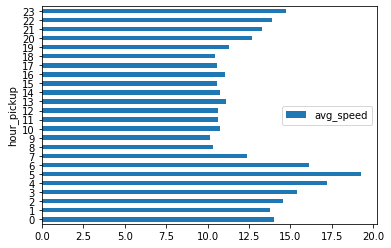

In [11]:
plot_start = time.time()
speedg = data1[['hour_pickup', 'avg_speed']]
speedg.plot.barh(x='hour_pickup', y='avg_speed', rot=0)


Plot of 10 most demanded trajectories

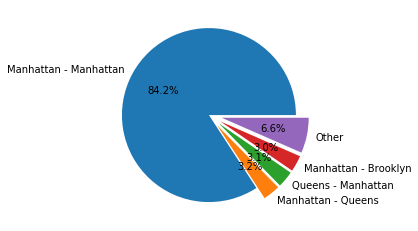

In [12]:
trips['id'] = trips.PUBorough + ' - ' + trips.DOBorough
tripsg = trips.iloc[0:4]
row = pd.DataFrame([['Other', 'Other', trips['count'].sum() - tripsg['count'].sum(), 'Other']], 
                  columns = ["DOBorough", "PUBorough", "count", "id"])
tripsg = tripsg.append(row)
plt.pie(tripsg['count'],
    labels=tripsg['id'],
    explode=(0, 0.15, 0.15, 0.15, 0.15),
    autopct='%1.1f%%',
    )
plt.show()

Plot of percentage of tips

In [13]:
zone_data

,PUBorough,DOBorough,count,tip_percent
0,Manhattan,Manhattan,1623207,0.140910
1,Manhattan,Queens,61378,0.149898
2,Queens,Manhattan,59001,0.165497
3,Manhattan,Brooklyn,58047,0.143412
4,Unknown,Unknown,29207,0.137809
5,Queens,Queens,27501,0.092013
6,Brooklyn,Brooklyn,20064,0.125300
7,Queens,Brooklyn,14630,0.131777
8,Manhattan,Bronx,9616,0.071243
9,Brooklyn,Manhattan,8604,0.140157


In [14]:
zone_data = zone_data.sort_values(by=['count'],ascending = False)
zone_data['id'] = zone_data.PUBorough + ' - ' + zone_data.DOBorough
zone_data_subset = zone_data.iloc[0:10]
zoneg = zone_data_subset[['id', 'tip_percent', 'count']]
zoneg.set_index('id')
#zoneg

,tip_percent,count
id,,
Manhattan - Manhattan,0.140910,1623207
Manhattan - Queens,0.149898,61378
Queens - Manhattan,0.165497,59001
Manhattan - Brooklyn,0.143412,58047
Unknown - Unknown,0.137809,29207
Queens - Queens,0.092013,27501
Brooklyn - Brooklyn,0.125300,20064
Queens - Brooklyn,0.131777,14630
Manhattan - Bronx,0.071243,9616


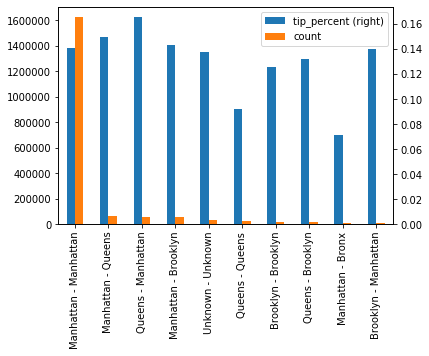

In [15]:
fig = zoneg.plot( kind= 'bar' , secondary_y= 'tip_percent' , rot= 90 )
fig.set_xticklabels(zoneg.id)
plot_end = time.time()

Measure of times of the different parts of the code:

In [16]:
print("Preprocessing time in serial: " + str(prep_end - start) + " seconds")
print("Average speed calculation in serial: " + str(avg_speed_end - avg_speed_start) + " seconds")
print("Number of trips by zone of travel and average of tips: " + str(zone_end - zones_start)+ " seconds")
print("Calculation of mean by type of travel: " + str(distances_end -distances_start)+  " seconds")
print("Plot time (includes df transformation): " + str(plot_end - plot_start)+ " seconds")
print("Total time in serial: " + str(distances_end - start)+ " seconds")

Preprocessing time in serial: 23.02477741241455 seconds
Average speed calculation in serial: 4.1460020542144775 seconds
Number of trips by zone of travel and average of tips: 1.8663361072540283 seconds
Calculation of mean by type of travel: 0.993537425994873 seconds
Plot time (includes df transformation): 2.5979676246643066 seconds
Total time in serial: 30.252633810043335 seconds
